In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym
import sys
import math

In [52]:
env = gym.make('MountainCar-v0')

In [53]:
# Discretizer is a class to discretize the observation space.
class Discretizer:
    # discretizes [low, high] space to a grid with grid_shape shape
    def __init__(self, low, high, grid_shape):
        self.grids = []
        for i in range(low.shape[0]):
            gap = (high[i] - low[i]) / grid_shape[i]
            self.grids.append([low[i] + j * gap for j in range(1, grid_shape[i])])
    
    def grid_shape(self):
        return tuple([len(grid) + 1 for grid in self.grids])

    def discretize_state(self, state):
        return tuple([np.digitize(state[i], self.grids[i]) for i in range(len(state))])


print("Low:\t", env.observation_space.low)
print("High:\t", env.observation_space.high)
discretizer = Discretizer(env.observation_space.low, env.observation_space.high, (20, 20))
print(discretizer.discretize_state([-1.2, -0.07]))
print(discretizer.discretize_state([1.2, 0.07]))

Low:	 [-1.2  -0.07]
High:	 [0.6  0.07]
(0, 0)
(19, 19)


In [54]:
# Agent using Q-learning algorithm.
class Agent:
    def __init__(self, env, states_shape, alpha=0.02, gamma=0.99, epsilon=0.1):
        self.actions_n = env.action_space.n
        self.states_shape = states_shape
        self.Q = np.zeros(states_shape + (self.actions_n,))
        
        # alpha --- learning rate
        self.alpha = alpha
        # gamma --- discount factor
        self.gamma = gamma
        # epsilon for epsilon-greedy policy
        self.epsilon = epsilon

    def max_policy(self, state):
        return np.argmax(self.Q[state])
    
    def eps_greedy_policy(self, state):
        if np.random.random() < self.epsilon:
            return np.random.choice(self.actions_n)
        else:
            return self.max_policy(state)
        
    def learn(self, state, action, new_state, reward):
        self.Q[state + (action,)] += self.alpha * \
            (reward + self.gamma * max(self.Q[new_state]) - self.Q[state + (action,)])


agent = Agent(env, discretizer.grid_shape())

In [55]:
# Reward agent with the reward from the env and when it has high speed.
def process_reward(state, action, new_state, reward):
    return reward + 100 * (abs(new_state[1]))**2

In [56]:
# Train agent episode_n times.
def train(env, agent, episode_n=40000):
    scores = []
    # batches are only used for outputing the average score.
    batch_sz = 100
    batch_avg_scores = []
    for episode in range(1, episode_n+1):
        state = discretizer.discretize_state(env.reset())
        done = False
        total_reward = 0
        
        while not done:
            action = agent.eps_greedy_policy(state)
            new_state, reward, done, info = env.step(action)
            total_reward += reward
            reward = process_reward(state, action, new_state, reward)
            new_state = discretizer.discretize_state(new_state)
            agent.learn(state, action, new_state, reward)
            state = new_state
        
        scores.append(total_reward)
        
        if (episode % batch_sz == 0):
            batch_avg_scores.append(np.mean(scores[-batch_sz:]))
            print("\rEpisode {} out of {}, approximate score: {}".format(
                episode,
                episode_n,
                np.max(batch_avg_scores)),
                end=""
            )
            sys.stdout.flush()

    return scores


scores = train(env, agent)

Episode 40000 out of 40000, approximate score: -132.77

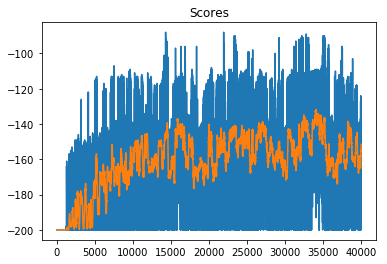

In [36]:
# Plot episode_number - score dependency.
plt.plot(scores);
plt.title("Scores");
plt.plot(pd.Series(scores).rolling(100).mean());

In [51]:
# Show agent in action.
state = env.reset()
score = 0
done = False
while not done:
    action = agent.max_policy(discretizer.discretize_state(state))
    env.render()
    state, reward, done, info = env.step(action)
    score += reward
print('Score:', score)
env.close()

Score: -143.0
